<font size = 6>基础设置

这段代码导入了一些常用的库和模块，并设置了一些绘图和字体的参数。

In [3]:
from stock_data import *  
#这行代码导入了一个名为 stock_data 的自定义模块。* 表示导入模块中的所有内容，这样你可以直接使用该模块中定义的函数、类或变量。
from pandas.plotting import register_matplotlib_converters
#这两行代码导入了 pandas 库的 register_matplotlib_converters 函数，并调用该函数。这个函数的作用是注册 matplotlib 转换器，以便在绘制时间序列图时正确处理日期数据。
register_matplotlib_converters()
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False
#这两行代码设置了 matplotlib 的全局参数。第一行指定了字体为 "SimHei"，用于支持中文显示。第二行设置了 unicode_minus 参数为 False，以解决绘图时负号显示为方块的问题。
import numpy as np
import copy
#这行代码导入了 copy 模块，用于进行对象的复制操作。
from scipy.stats import spearmanr
#这行代码从 scipy.stats 模块中导入了 spearmanr 函数，用于计算数据的斯皮尔曼相关系数。

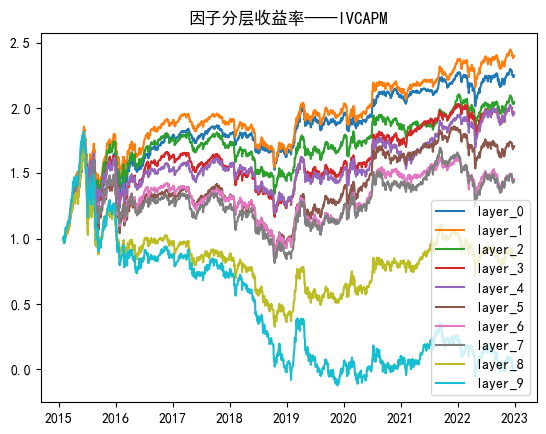

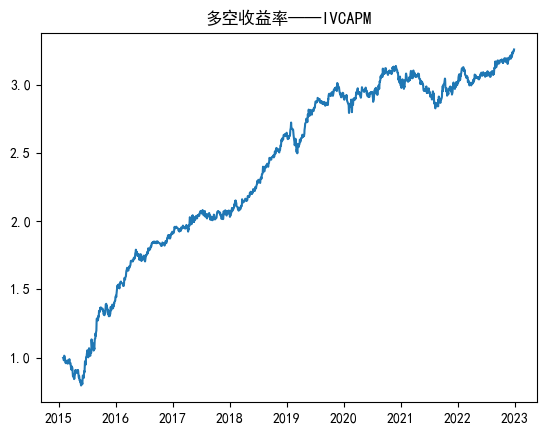

d:\Anaconda\envs\TwentyThree\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\Anaconda\envs\TwentyThree\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
d:\Anaconda\envs\TwentyThree\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


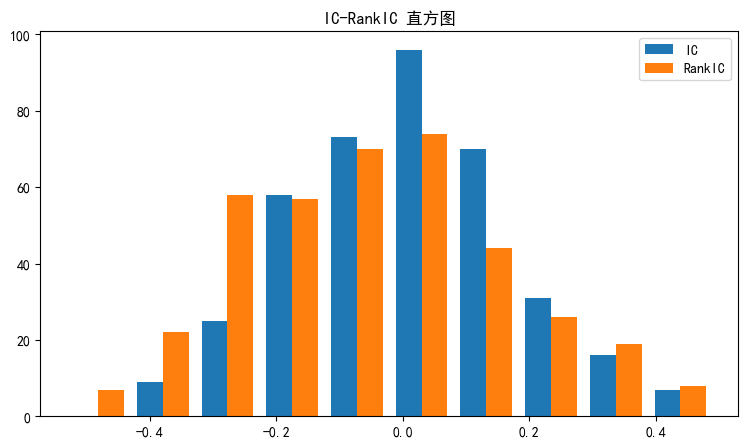

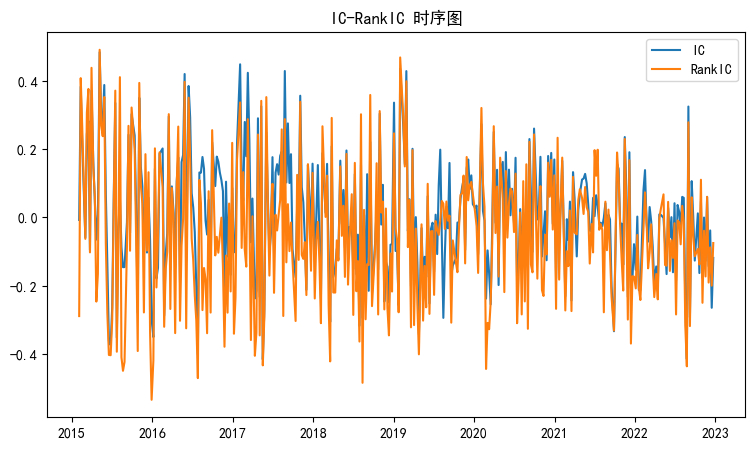

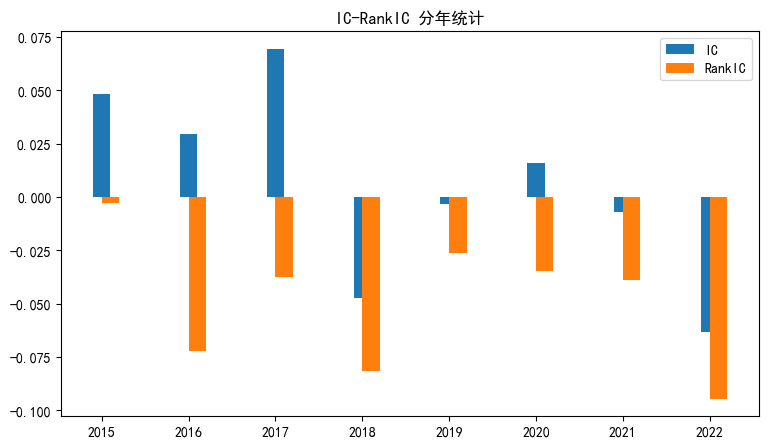

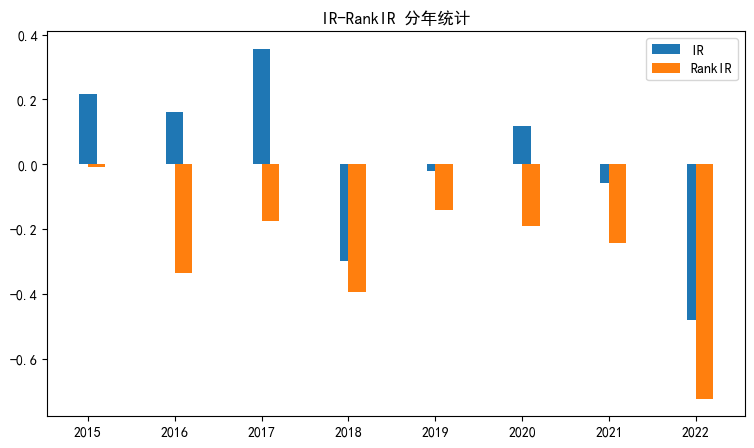

In [4]:
class Backtester(object): #定义名为Backtester的类，用于执行回测操作
    def __init__(self):
        pass #初始化不执行任何操作，使用pass语句占位

    def set_data_obj(self, data_obj):
        self.data_obj = data_obj
        self.date_list = list(self.data_obj.factor_dict['amount'].index)
        self.symbol_list = list(self.data_obj.symbol_list)
        self.factor_name = self.data_obj.decision_factor
        self.factor_path = 'factor_result\\' + self.factor_name +'\\'
        if not os.path.exists(self.factor_path):
            os.makedirs(self.factor_path)

    def set_backtest_para(self, para):
        self.decision_freq = para['decision_freq']   #决策频率
        self.fee = para['fee']                       #手续费

    def backtest_engine(self):
        #这几行初始化了一些用零填充的数组，用于存储回测过程中的数据
        self.posList = np.zeros((len(self.date_list), len(self.symbol_list)))
        #self.posList用于存储每个日期每只股票的持仓量
        self.hold_days = np.zeros((len(self.date_list), len(self.symbol_list)))
        #self.hold_days用于存储每个日期每个股票的持仓天数
        self.blank_days = np.zeros((len(self.date_list), len(self.symbol_list)))
        #self.blank_days用于存储每个日期和每个股票的空仓天数
        self.hold_rtn = np.zeros((len(self.date_list), len(self.symbol_list)))
        #self.hold_rtn用于存储每个日期和每个股票的持仓收益率
        self.pre_pos = np.zeros(len(self.symbol_list))
        #self.pre_pos用于存储前一日期的持仓量
        for k in range(1, len(self.date_list)): #从第二个日期开始遍历回测日期列表中的每个日期
            #调用策略函数
            pos = self.call_strategy(k-1) #在每个日期上调用self.call_strategy方法，并将k-1作为参数传递给它，以获取策略函数返回的持仓数据pos
            # 计算可实现的交易
            pos_chg_t = pos - self.pre_pos    # 理论持仓变化，即当前持仓量pos减去前一日期的持仓量self.pre_pos
            buy_f = self.data_obj.factor_arr_dict['buy_flag'][k] #获取买入标志的数据
            sell_f = self.data_obj.factor_arr_dict['sell_flag'][k] #获取卖出标志的数据
            pos_chg_t[(pos_chg_t < 0) & (sell_f == 0)] = 0 #如果pos_chg_t小于零且卖出标志为零，则将持仓变化设为零
            pos_chg_t[(pos_chg_t > 0) & (buy_f == 0)] = 0 #如果pos_chg_t大于零且买入标志为零，则将持仓变化设为零。
            pos_tmp = self.pre_pos + pos_chg_t #计算新的持仓量，即前一日期的持仓量self.pre_pos加上pos_chg_t
            if pos_tmp.sum() > 1: #如果新的持仓量总和大于1，则需要进行调整
                idx_tmp = np.where((pos_chg_t > 0) & (buy_f != 0))[0]
                #找到满足条件的索引idx_tmp，即pos_chg_t大于零且买入标志不为零的索引，并对这些索引对应的持仓变化量进行调整，以确保总持仓量不超过1。
                pos_chg_t[idx_tmp] = pos_chg_t[idx_tmp] - (pos_tmp.sum()-1.0)/len(idx_tmp)
            self.posList[k] = self.pre_pos + pos_chg_t #第k日的持仓等于前一日的持仓量加上持仓变化量

            #计算个股的持仓天数和持仓收益率
            idx = np.where(self.posList[k]>0) #使用np.where函数找到持仓量大于零的股票的索引idx
            self.hold_days[k, idx] = self.hold_days[k - 1, idx] + 1 #更新这些股票的持仓天数，持仓天数的计算是基于前一日期的持仓天数加1
            self.hold_rtn[k, idx] = (1 + self.hold_rtn[k - 1, idx]) * (1 + self.data_obj.factor_arr_dict['HRTN'][k, idx]) - 1
            #更新这些股票的持仓收益率，持仓收益率的计算是基于前一日期的持仓收益率乘以当前日期的因子收益率加1，再减去1
            self.pre_pos = copy.deepcopy(self.posList[k]) #将当前日期的持仓量self.posList[k]赋值给self.pre_pos，以备下一个日期的计算使用
            idx1 = np.where(self.posList[k] == 0) #使用np.where函数找到持仓量为零的股票的索引idx1
            self.blank_days[k, idx1] = self.blank_days[k - 1, idx1] + 1 #更新这些股票的空仓天数。

        self.positionDF = pd.DataFrame(self.posList, index=self.date_list, columns=self.symbol_list)
        self.hold_days_DF = pd.DataFrame(self.hold_days, index=self.date_list, columns=self.symbol_list)
        self.hold_rtn_DF = pd.DataFrame(self.hold_rtn, index=self.date_list, columns=self.symbol_list)
        '''使用pd.DataFrame创建了三个DataFrame对象，分别存储了持仓量、持仓天数和持仓收益率的数据，
        这些数据是基于self.posList、self.hold_days和self.hold_rtn数组生成的'''

        self.turnover = self.positionDF.diff(1).abs().fillna(0) #计算换手率，即持仓量的差值的绝对值，用0填充缺失值
        self.turnover_ser = self.turnover.sum(axis=1) #计算换手率序列，即将换手率按行求和
        self.compute_pnl()
        #计算回测的盈亏

        self.compute_report()
        #生成回测的报告

        self.plot_data()
        #绘制图表

        a = 1

    def call_strategy(self, k): #策略函数
        # 定位当天的指数成分股
        idx = self.data_obj.factor_arr_dict['index_weight'][k] > 0  
        #获取当天指数权重数据（index_weight），并检查哪些股票的权重大于零。
        pos_idx = np.where(idx == True)[0] #它使用np.where函数找到权重大于零的股票的索引，存储在pos_idx
        if np.mod(k,self.decision_freq) != 0:
            pos = copy.deepcopy(self.pre_pos)
            #检查当前日期k是否是决策频率（decision_freq）的倍数。如果不是，则返回前一日期的持仓数据self.pre_pos。
            idx_close = np.where((idx == False))[0]
            #使用np.where找到权重为零的股票的索引idx_close，并将这些股票的持仓量设为零
            pos[idx_close] = 0 #返回持仓数据pos
            return pos
        
        else:
            pos = np.zeros(len(self.symbol_list))
            #如果当前日期是决策频率的倍数，则将持仓数据pos初始化为零

        # 准备决策数据并处理异常值
        pe_ttm = self.data_obj.factor_arr_dict[self.data_obj.factor_list[0]][k, idx]
        #从因子数据中获取第一个因子（factor_list[0]）的第k行（第k日），并将其存储在pe_ttm中
        pe_ttm[np.isnan(pe_ttm)] = 999
        pe_ttm[pe_ttm < 0] = 999
        #pe_ttm中的缺失值（NaN）替换为999，并将小于零的值也替换为999
        hold_num = int(len(pe_ttm) * 0.5)
        #计算持仓股票数量hold_num，该数量为指数成分股数量的一半

        ridx1 = np.argsort(pe_ttm)
        #对pe_ttm进行排序，获取排序后的索引ridx1
        index1 = np.zeros(len(pe_ttm))
        #创建一个与pe_ttm长度相同的零数组index1
        index1[ridx1] = range(len(pe_ttm))
        #将排序后的索引值赋值给相应的位置

        index = index1
        idx_trade = np.argsort(index)[:hold_num]
        #对index进行排序，并获取排序后的前hold_num个索引idx_trade
        target_idx = pos_idx[idx_trade]
        #从指数成分股的索引pos_idx中选择这些索引对应的股票，存储在target_idx中

        if len(target_idx) > 0:
            pos[target_idx] = 1.0/len(target_idx)
        return pos
    
    '''以上这就是call_strategy策略函数。它根据特定的策略逻辑生成每个日期的持仓数据。'''

    # 因子IC分析
    def factor_ananlyse_ic(self):
        rtn_length = 5
        ic_date_list = []
        for k in range(1, len(self.date_list)-rtn_length, rtn_length):
            factor_arr = self.data_obj.factor_arr_dict[self.factor_name][k, :]
            #获取相应日期的因子数据factor_arr
            idx = ~np.isnan(factor_arr)
            factor_arr = factor_arr[idx]
            rtn_arr = np.array(self.data_obj.factor_dict['HRTN'].loc[:,idx].iloc[k+1:k+rtn_length, :].sum(0))
            #获取对应的收益率数据rtn_arr，该收益率是未来rtn_length个日期的收益率之和
            corr = np.corrcoef(factor_arr, rtn_arr)
            #使用np.corrcoef计算因子数据和收益率数据之间的相关系数corr
            correlation, p_value = spearmanr(factor_arr, rtn_arr)
            #使用spearmanr函数计算因子数据和收益率数据之间的Spearman秩相关系数correlation和对应的p值
            ic_date_list.append([self.date_list[k], corr[0,1], correlation])
            #将日期、相关系数和秩相关系数添加到ic_date_list中

        ic_df = pd.DataFrame(ic_date_list, columns=['date','IC','RankIC'])
        ic_df.set_index('date',inplace=True)
        #将ic_date_list转换为DataFrame，并设置日期为索引

        year_list = list(range(ic_df.index[0].year,ic_df.index[-1].year+1))
        year_ic_list = []
        #确定年份的范围，并创建一个空列表year_ic_list
        for year in year_list:
            this_ic_df = ic_df.loc[str(year), :]
            year_ic_list.append([str(year)] + list(this_ic_df.mean())+ list(this_ic_df.mean()/this_ic_df.std()) )
            #循环遍历每个年份，从ic_df中获取该年份的数据，并计算平均值、标准差和IR
        year_ic_df = pd.DataFrame(year_ic_list, columns=['year','IC','RankIC','IR','RankIR'])
        ## 绘图
        plt.figure(figsize=(9, 5))
        plt.title('IC-RankIC 直方图')
        plt.hist(ic_df)
        plt.legend(['IC','RankIC'])
        # plt.show()
        plt.savefig(self.factor_path+ '\\IC_series.png')
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.title('IC-RankIC 时序图')
        plt.plot(ic_df)
        plt.legend(['IC', 'RankIC'])
        # plt.show()
        plt.savefig(self.factor_path + '\\IC_hist.png')
        plt.show()

        year_ic_df.index = year_ic_df['year']
        plt.figure(figsize=(9, 5))
        plt.title('IC-RankIC 分年统计')
        plt.bar(year_ic_df.index, year_ic_df['IC'], align='center', width=0.2)
        plt.bar(year_ic_df.index, year_ic_df['RankIC'], align='edge', width=0.2)
        plt.legend(['IC', 'RankIC'])
        # plt.show()
        plt.savefig(self.factor_path + '\\IC_year.png')
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.title('IR-RankIR 分年统计')
        plt.bar(year_ic_df.index, year_ic_df['IR'], align='center', width=0.2)
        plt.bar(year_ic_df.index, year_ic_df['RankIR'], align='edge', width=0.2)
        plt.legend(['IR', 'RankIR'])
        # plt.show()
        plt.savefig(self.factor_path + '\\IR_year.png')
        plt.show()
        a = 1

    # 因子分层分析
    def factor_ananlyse_group(self):
        layer_rtn = pd.DataFrame(0., index=self.date_list, columns=list(range(10)))
        #创建了一个名为layer_rtn的DataFrame，用于存储每个日期的分层收益率结果
        ls_rtn_list = []
        date_list = []
        #创建一个空列表ls_rtn_list和一个空列表date_list，用于存储分层收益率的差异结果和日期列表。
        for k in range(1, len(self.date_list)-1):
            idx = self.data_obj.factor_arr_dict['index_weight'][k] > 0 #获取成分股索引
            factor_arr = self.data_obj.factor_dict[self.factor_name].iloc[k, idx] #获取当日因子值
            if len(factor_arr) == 0:
                continue #如果factor_arr的长度为零，说明在该日期没有因子数据可用，那么跳过该日期的计算。
            rtn_arr = self.data_obj.factor_dict['HRTN'].iloc[k + 1, idx] #从收益率数据中获取下一个日期的收益率
            idx2 = ~np.isnan(factor_arr) #使用~np.isnan过滤掉因子数据和收益率数据中的缺失值
            factor_arr = factor_arr[idx2] 
            rtn_arr = rtn_arr[idx2]
            #过滤后的因子数据和收益率数据存储在factor_arr和rtn_arr中。

            # 分层
            factor_arr.drop_duplicates(inplace=True) #使用drop_duplicates方法去除因子数据中的重复值
            factor_df_layers = pd.qcut(factor_arr, 10, labels=False, duplicates='drop')
            #使用pd.qcut函数将因子数据分为10个分层，并使用labels=False表示使用数字而不是标签来表示分层。duplicates='drop'参数用于删除重复值所在的分层。
            factor_df_layers.dropna(inplace=True) #使用dropna方法去除分层数据中的缺失值
            if factor_df_layers is None or len(factor_df_layers) == 0:
                continue #如果分层数据为空或长度为零，则跳过该日期的计算
            date_list.append(self.date_list[k]) #最后，它将该日期添加到date_list中。
            # 合并分层结果和收益率
            merged_df = pd.concat([factor_df_layers, rtn_arr], axis=1)
            #首先使用pd.concat函数将分层数据和收益率数据按列合并为一个DataFrame。
            merged_df.columns = ['layer', 'return']
            #给合并后的DataFrame的列命名为'layer'和'return'。
            avg_returns_by_layer = merged_df.groupby('layer').mean()
            #使用groupby方法按分层进行分组，并计算每个分层的平均收益率
            avg_returns_by_layer.index = avg_returns_by_layer.index.astype(int)
            #为了确保分层索引为整数类型，它使用astype(int)进行类型转换
            layer_count = merged_df.groupby('layer').count()
            #使用groupby方法计算每个分层的样本数量
            layer_rtn.iloc[k, avg_returns_by_layer.index] = avg_returns_by_layer.iloc[:, 0]
            #将每个分层的平均收益率存储在layer_rtn中相应的位置
            ls_rtn_list.append(avg_returns_by_layer.iloc[0] - avg_returns_by_layer.iloc[-1])
            #将分层的多空收益率添加到ls_rtn_list中，做多分层的第一组，做空分层的最后一组

        plt.title('因子分层收益率——'+ self.factor_name)
        layer_nav = layer_rtn.cumsum() + 1
        plt.plot(pd.DataFrame(layer_nav, index=date_list))
        plt.legend(['layer_' + str(x) for x in range(10)])
        plt.savefig(self.factor_path + '\\layer_rtn.png')
        plt.show()


        plt.title('多空收益率——'+self.factor_name)
        ls_nav = np.array(ls_rtn_list).cumsum() + 1
        plt.plot(pd.Series(ls_nav,index=date_list))
        plt.savefig(self.factor_path + '\\ls_rtn.png')
        plt.show()
        a = 1

    # 因子共线性分析
    def factor_analyse_corr(self):
        #将因子数据转换为适合进行共线性分析的格式
        ser_list = []
        for factor in self.data_obj.factor_list: #遍历self.data_obj.factor_list中的每个因子
            df = self.data_obj.factor_dict[factor] #将每个因子的数据转换成一个序列（Series）
            ser_list.append(df.stack()) 
        stack_df = pd.concat(ser_list,axis=1) #将所有序列合并为一个DataFrame stack_df
        stack_df.dropna(inplace=True) #使用drop方法去除包含缺失值的行
        stack_df.columns = self.data_obj.factor_list #将列命名为因子列表中对应的因子名称
        corr = stack_df.corr() #它使用corr方法计算stack_df中各列之间的相关系数
        corr.columns = self.data_obj.factor_list
        corr.index = self.data_obj.factor_list
        #将列和行的标签设置为因子列表中对应的因子名称

        # 绘制相关系数矩阵热力图
        import seaborn as sns
        import matplotlib.pyplot as plt

        sns.heatmap(corr, annot=True, cmap='coolwarm')
        #使用heatmap函数绘制热力图，其中annot=True表示在每个格子中显示相关系数的值，cmap='coolwarm'表示使用冷暖色调来表示相关性的强度
        plt.show()

        from statsmodels.stats.outliers_influence import variance_inflation_factor
        # 进行因子共线性分析
        vif = pd.DataFrame()
        vif["Features"] = self.data_obj.factor_list
        vif["VIF"] = [variance_inflation_factor(stack_df.values, i) for i in range(stack_df.shape[1])]
        #使用statsmodels.stats.outliers_influence模块的variance_inflation_factor函数计算因子之间的方差膨胀因子（VIF）
        #创建一个空的DataFrame vif，并将因子列表存储在"Features"列中。然后，它使用循环计算每个因子的VIF，并将结果存储在"VIF"列中

        print(vif)

        # 使用正交化方法消除共线性
        from sklearn.decomposition import PCA #使用sklearn.decomposition模块的PCA（主成分分析）方法进行因子正交化处理
        pca = PCA(n_components=stack_df.shape[1]) #创建一个PCA对象，并将主成分的数量设置为stack_df的列数
        orthogonal_factors = pca.fit_transform(stack_df) #使用fit_transform方法对stack_df进行主成分分析，并得到正交化后的因子数据orthogonal_factors
        orthogonal_df = pd.DataFrame(orthogonal_factors, columns=stack_df.columns)
        #将正交化后的因子数据存储在DataFrame orthogonal_df中，并将列命名为原始因子列表中对应的因子名称
        corr2 = orthogonal_df.corr()
        #计算正交化后的因子数据的相关系数矩阵corr2
        pass


    #  PE_ttm and int_to_talcap
    def call_strategy_2(self, k):
        idx = self.data_obj.factor_arr_dict['index_weight'][k] > 0  # 定位当天的指数成分股
        pos_idx = np.where(idx == True)[0]
        if np.mod(k,self.decision_freq) != 0:
            pos = copy.deepcopy(self.pre_pos)
            idx_close = np.where((idx == False))[0]
            pos[idx_close] = 0
            return pos
        #更新第k天的持仓数据
        #如果k除以self.decision_freq的余数不等于0，说明当前不是决策日，将pos设置为前一个决策日的持仓情况，并将指数成分股中不在idx中的股票的持仓置为0。然后，返回pos
        else:
            pos = np.zeros(len(self.symbol_list))
        #如果是决策日，则将pos初始化为全0的数组，即初始化持仓数据

        # 准备决策数据并处理异常值
        pe_ttm = self.data_obj.factor_arr_dict['pe_ttm'][k, idx]
        int_to_talcap = self.data_obj.factor_arr_dict['int_to_talcap'][k, idx]
        #从self.data_obj.factor_arr_dict中获取名为'pe_ttm'和'int_to_talcap'的因子数据，并根据idx获取当天的指数成分股的数据。
        pe_ttm[np.isnan(pe_ttm)] = 999
        pe_ttm[pe_ttm < 0] = 999
        int_to_talcap[np.isnan(int_to_talcap)] = 999
        int_to_talcap[int_to_talcap < 0] = 999
        #将其中的NaN值替换为999，将小于0的值替换为999。

        hold_num = int(len(pe_ttm) * 0.1)
        # hold_num = 20
        ridx1 = np.argsort(pe_ttm)
        #根据pe_ttm进行排序，将排序后的索引存储在ridx1中
        index1 = np.zeros(len(pe_ttm))
        #创建一个与pe_ttm长度相同的全0数组index1
        index1[ridx1] = range(len(pe_ttm))
        #将排序后的索引赋值给index1对应的位置

        ridx2 = np.argsort(int_to_talcap)
        index2 = np.zeros(len(pe_ttm))
        index2[ridx2] = range(len(pe_ttm))
        #同上述对pe_ttm因子的操作

        index = index1 + index2
        #index = index1 + index2的作用是将index1和index2两个排序结果进行综合排序。
        idx_trdae = np.argsort(index)[:hold_num] #根据综合排序结果的前hold_num个索引，获取对应的指数成分股的索引
        target_idx = pos_idx[idx_trdae] #将对应的指数成分股的索引，存储在target_idx中

        if len(target_idx) > 0:
            pos[target_idx] = 1.0/len(target_idx)
            #这部分代码根据筛选出的指数成分股的索引，将对应的持仓比例设置为1.0/len(target_idx)，即等权分配
        return pos #返回持仓比例数组pos

    
    def compute_pnl(self): #用于计算收益和交易费用
        arr_pos_L = copy.deepcopy(self.posList)
        arr_pos_L[arr_pos_L <= 0] = 0 #将非正数的持仓量设为0

        # 将交易拆分成开仓，平仓，持仓 3种情况
        pos_shift = np.insert(arr_pos_L[:-1, :], 0, np.zeros_like(arr_pos_L[0]), axis=0)
        # 创建pos_shift变量。它通过在arr_pos_L的第一行之前插入一个与arr_pos_L[0]形状相同的全零数组，得到了一个向下偏移的arr_pos_L。
        pos_diff = np.insert(np.diff(arr_pos_L, axis=0), 0, arr_pos_L[0], axis=0)
        # 创建了pos_diff变量。它通过计算arr_pos_L在时间轴上的差分，得到了相邻时间点的持仓量变化。然后，插入arr_pos_L[0]作为第一行，得到了一个与arr_pos_L形状相同的向下偏移的持仓量变化数组
        pos_LB = copy.deepcopy(pos_diff)
        pos_LS = copy.deepcopy(pos_diff)
        pos_LB[pos_LB < 0] = 0 #将小于0的元素设为0（开仓情况）
        pos_LS[pos_LS > 0] = 0 #大于0的元素设为0（平仓情况）
        pos_LH = pos_shift #创建了pos_LH变量，表示持仓情况下的交易量，初始化为pos_shift
        pos_LH[pos_LH >= arr_pos_L] = arr_pos_L[pos_LH >= arr_pos_L]
        #将pos_LH中大于等于arr_pos_L的元素设为对应的arr_pos_L的值，以确保持仓量不会超过实际持仓量

        #分别计算了持仓、开仓和平仓情况下的收益
        PRtnHold = pos_LH * self.data_obj.factor_arr_dict['HRTN']
        #PRtnHold表示持仓所产生的收益，等于pos_LH乘以self.data_obj.factor_arr_dict['HRTN']，即持仓量乘以持仓期间的收益率
        PRtnBuy = pos_LB * (self.data_obj.factor_arr_dict['ORTN'] - self.fee)
        #PRtnBuy表示开仓所产生的收益，等于pos_LB乘以开仓时的收益率减去交易费用self.fee
        PRtnSell = -1 * pos_LS * (self.data_obj.factor_arr_dict['CRTN'] - self.fee)
        #PRtnSell表示平仓所产生的收益，等于pos_LS乘以平仓时的收益率减去交易费用self.fee

        PRtnTotal = PRtnHold + PRtnBuy + PRtnSell
        #将持仓、开仓和平仓情况下的收益相加，得到总收益PRtnTotal
        self.PRtnTotal = pd.DataFrame(PRtnTotal, index=self.date_list, columns=self.symbol_list)
        #将总收益PRtnTotal转换为一个pd.DataFrame对象，并使用self.date_list作为索引，self.symbol_list作为列名
        self.pnl = self.PRtnTotal.sum(1)
        #计算每个时间点的总收益，并将结果存储在self.pnl中。它通过对self.PRtnTotal的每一行求和，得到一个包含每个时间点总收益的pd.Series对象

        self.trade_fee = (np.abs(pos_LB) + np.abs(pos_LS))* self.fee
        #这行代码计算了每个时间点的交易费用。它将开仓和平仓的交易量取绝对值后相加，再乘以交易费用self.fee，得到每个时间点的交易费用self.trade_fee
        self.trade_fee_ser = self.trade_fee.sum(1)
        #计算了每个时间点的总交易费用，并将结果存储在self.trade_fee_ser中。它通过对self.trade_fee的每一行求和，得到一个包含每个时间点总交易费用的pd.Series对象。
        a = 1 #暂时的占位符

    
    #定义名为compute_report的方法，用于计算交易策略的报告
    def compute_report(self):
        self.report = pd.DataFrame(
            columns=['tradeDays', 'totalRtn', 'YearlyRtn', 'YearlyVol', 'Maxdd', 'Sharp', 'Calmar',
                     'indexRtn', 'totalRtn_excess', 'yearlyRtn_excess', 'yearlyVol_excess', 'maxDD_excess', 'sharp_excess',
                     'calmar_excess', 'Turnover'])
        #创建了一个空的pd.DataFrame对象，名为self.report，它包含了报告中的各个指标列

        pnl_year = self.pnl.resample('A').sum()
        #对策略收益self.pnl进行按年重采样，并计算每年的总收益，结果存储在pnl_year中。

        self.index_pnl = self.data_obj.index_daily['pct_chg'].loc[self.date_list]
        #从数据对象self.data_obj中获取基准指数的每日收益率，并根据self.date_list筛选出与策略收益对应的日期，将结果存储在self.index_pnl中

        for y in pnl_year.index: #循环遍历pnl_year中的每个年份
            self.report.loc[str(y.year), :] = self.computeIndicator(self.pnl[str(y.year)], self.index_pnl[str(y.year)], np.array(self.turnover[str(y.year)]))
            #调用computeIndicator方法计算该年份的各项指标，然后将结果存储在self.report对应的行中
        self.report.loc['Total', :] = self.computeIndicator(self.pnl, self.index_pnl, np.array(self.turnover))
        #计算整个策略历史期间的总指标，并将结果存储在self.report的'Total'行中
        self.hold_num = self.positionDF.apply(np.sign).sum(axis=1)
        #计算每个时间点持仓的标的数量
        self.hold_pct = self.positionDF.sum(axis=1)
        #计算每个时间点持仓的总市值
        self.nav = (self.pnl + 1).cumprod()
        # 计算策略净值
        self.index_nav = (self.index_pnl + 1).cumprod()
        # 计算基准净值
        self.excess_nav = (self.pnl - self.index_pnl + 1).cumprod()
        # 计算超额净值
        #这几行代码均是通过cumprod()方法对收益率序列进行累积乘积计算

        self.report_show = self.report.loc[:,[ 'totalRtn', 'indexRtn','totalRtn_excess', 'YearlyVol', 'Maxdd', 'Sharp', 'Calmar', 'Turnover']]
        self.report_show.columns = ['策略收益率','基准收益率','超额收益率', '波动率', '最大回撤', '夏普', '卡玛', '换手率']
        self.report_show = self.report_show.round(3)
        #从完整的报告中选择了一部分指标列，并对列名进行了重命名和格式化处理，得到一个用于显示的报告表格self.report_show。
        pd.set_option('display.float_format', '{:.3f}'.format)
        self.report_show.to_excel('report.xlsx')
        #这两行代码设置了浮点数的显示格式，并将报告表格self.report_show保存为Excel文件，文件名为'report.xlsx'

    def computeIndicator(self, dailyPnl, pnl_index, turnover):
        try:
            startDate = dailyPnl.loc[dailyPnl != 0].index[0]
            startIdx = list(dailyPnl.index).index(startDate)
            dailyPnl = dailyPnl.iloc[startIdx:]
            '''try-except块用于处理dailyPnl中的零值。它首先找到第一个非零值的日期，
            并将其作为起始日期startDate，然后找到该日期在索引中的位置startIdx。
            接下来，它将dailyPnl从起始日期开始的部分切片赋值给dailyPnl，以去除起始日期之前的零值。'''
        except:
            pass

        tradeDays = dailyPnl.shape[0] #计算交易天数
        totalRtn = (dailyPnl + 1).cumprod()[-1] - 1 #计算总收益率，总收益率通过对dailyPnl加1后进行累积乘积计算得到。

        yearlyRtn = np.power(1 + totalRtn, 240.0 / tradeDays) - 1 
        #计算年化收益率，yearlyRtn。它使用总收益率totalRtn，将其加1后乘以年化因子240.0 / tradeDays，再减去1

        yearlyVol = dailyPnl.std() * np.sqrt(240)
        #计算了年化波动率yearlyVol。它使用dailyPnl的标准差乘以年化因子np.sqrt(240)得到

        #计算最大回撤
        nav = (dailyPnl + 1).cumprod()
        #首先计算净值序列nav
        tmpnav = np.maximum.accumulate(nav) - nav
        #计算每个时间点之前的最大净值tmpnav
        idx_e = tmpnav.idxmax()
        #找到最大回撤的结束点索引idx_e
        try:
            idx_s = nav[:idx_e].idxmax()
            #在最大回撤结束点索引之前的部分找到最大净值的起始点索引idx_s
            maxDD = -(nav[idx_e] - nav[idx_s]) / nav[idx_s]
            #计算最大回撤
        except:
            maxDD = 0.0

        if yearlyVol == 0.0:
            sharp = 0.0
        #如果年化波动率yearlyVol为0，则将夏普比率设为0
        else:
            sharp = yearlyRtn / yearlyVol
        #否则将年化收益率yearlyRtn除以年化波动率yearlyVol得到夏普比率
        
        #计算卡玛比率
        if maxDD == 0.0:
            calmar = 0.0
        #如果最大回撤maxDD为0，则将Calmar比率设为0
        else:
            calmar = yearlyRtn / maxDD
        #否则将年化收益率yearlyRtn除以最大回撤maxDD得到Calmar比率
        

        indexRtn = (pnl_index + 1).cumprod()[-1] - 1
        #计算基准收益率indexRtn。使用基准收益率序列pnl_index，将其加1后进行累积乘积计算得到
        excessDaily = dailyPnl - pnl_index
        #计算超额收益率指标，等于策略收益率减去基准收益率
        excessDaily.fillna(0,inplace=True)
        #将缺失值填充为0
        totalRtn_excess = (excessDaily + 1).cumprod()[-1] - 1
        #计算超额收益率的总收益率totalRtn_excess
        yearlyRtn_excess =  np.power(1 + totalRtn_excess, 240.0 / tradeDays) - 1
        #计算年超额收益率yearlyRtn_excess
        yearlyVol_excess = excessDaily.std() * np.sqrt(240)
        #计算年化超额收益波动率yearlyVol_excess


        #计算超额收益的最大回撤，计算方法与之前计算最大回撤类似
        navExcess = (excessDaily + 1).cumprod()
        tmpnav = np.maximum.accumulate(navExcess) - navExcess
        idx_e = tmpnav.idxmax()
        try:
            idx_s = navExcess[:idx_e].idxmax()
            maxDD_excess = -(navExcess[idx_e] - navExcess[idx_s]) / navExcess[idx_s]
        except:
            maxDD_excess = 0.0

        #计算超额收益率的夏普比率
        if yearlyVol_excess == 0.0:
            sharp_excess = 0.0
        else:
            sharp_excess = yearlyRtn_excess / yearlyVol_excess

        #计算超额收益的卡玛比率
        if maxDD == 0.0:
            calmar_excess = 0.0
        else:
            calmar_excess = yearlyRtn_excess / maxDD

        return [tradeDays, totalRtn, yearlyRtn,  yearlyVol, maxDD, sharp, calmar,
                indexRtn, totalRtn_excess, yearlyRtn_excess,  yearlyVol_excess, maxDD_excess, sharp_excess, calmar_excess,
                turnover.sum() / tradeDays /2]
    #计算各项指标后，返回包含这些指标的列表，其中turnover.sum() / tradeDays / 2: 平均换手率

    def plot_data(self):
        nav_df = pd.DataFrame(zip(self.nav, self.index_nav, self.excess_nav))
        plt.figure(figsize=(9, 5))
        plt.plot(self.date_list, nav_df, linewidth=2)
        # plt.xlabel('对数收益率')
        plt.ylabel('累计净值')
        plt.grid(True)
        plt.legend(['策略','基准','超额'])
        plt.show()

        pnl_year = self.pnl.resample('A').sum()
        pnl_index_year = self.index_pnl.resample('A').sum()
        year_rtn_df = pd.DataFrame(zip(pnl_year,pnl_index_year),index=[x.year for x in pnl_year.index ])
        plt.figure(figsize=(9, 5))
        year_rtn_df.plot.bar()
        plt.ylabel('年度收益率')
        plt.grid(True)
        plt.legend(['策略','基准'])
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.subplot(211)
        plt.plot(self.hold_num)
        plt.ylabel('持仓数量')
        plt.subplot(212)
        plt.plot(self.hold_pct*100)
        plt.ylabel('持仓比例（%）')
        plt.show()

        plt.figure(figsize=(9, 5))
        plt.subplot(211)
        plt.plot(self.turnover_ser *100)
        plt.ylabel('日换手率（%）')
        plt.subplot(212)
        plt.plot(self.trade_fee_ser)
        # plt.plot(np.cumsum(self.trade_fee_ser))
        plt.ylabel('手续费')
        plt.show()
        a = 1

#示例主程序，展示了如何使用之前定义的类和方法进行一系列操作
if __name__ == '__main__': 
    #首先，检查__name__变量是否等于'__main__'，这是Python中的惯用方式，用于判断是否直接运行当前脚本。
    # 如果是直接运行，则执行下面的代码块；如果是作为模块导入，则不执行下面的代码块。
    factor_list= ['IVCAPM']
    #创建一个factor_list列表，其中包含一个因子名字 'IVCAPM'。
    data_obj = StockData()
    #创建一个StockData对象，并命名为data_obj
    data_obj.set_index('000905.SH') #中证500
    #使用set_index方法设置指数代码为 '000905.SH'
    data_obj.set_date('2015-01-01', '2022-12-30')
    #使用set_date方法设置数据的起始日期为'2015-01-01'，结束日期为'2022-12-30'。
    data_obj.set_factor_list(factor_list)
    #使用set_factor_list方法设置因子列表为factor_list
    data_obj.load_index_data()
    #调用load_index_data方法加载指数数据
    data_obj.load_factor_data() #调用load_factor_data方法加载因子数据
    # data_obj.cumpute_deri_factor()
    data_obj.set_decision_factor(factor_list[0])
    #使用set_decision_factor方法设置决策因子为factor_list[0]，即'IVCAPM'

    bkt_obj = Backtester() #创建一个Backtester对象，并命名为bkt_obj
    bkt_obj.set_data_obj(data_obj) #使用set_data_obj方法将data_obj设置为bkt_obj的数据对象。
    bkt_obj.set_backtest_para({'decision_freq': 5,'fee':0.001}) 
    #使用set_backtest_para方法设置回测参数，包括决策频率为5天一次，交易费用为0.001。
    # bkt_obj.factor_analyse_corr()

    bkt_obj.factor_ananlyse_group() #调用factor_ananlyse_group方法进行因子分组分析
    bkt_obj.factor_ananlyse_ic() #调用factor_ananlyse_ic方法进行因子IC分析
    # bkt_obj.backtest_engine()
    a = 1